In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

In [63]:
def statfix(data, verbose=False):
    q0 = data.quantile(0)
    q1 = data.quantile(.25)
    q2 = data.quantile(.5)
    q3 = data.quantile(.75)
    q4 = data.quantile(1)
    if verbose:
        print(f'0 QUANTILE: {q0}')
        print(f'25 QUANTILE: {q1}')
        print(f'50 QUANTILE: {q2}')
        print(f'75 QUANTILE: {q3}')
        print(f'100 QUANTILE: {q4}')

        print('\n')

        print(f'Standart Deviation: {data.std()}')
        print(f'Median: {data.median()}')
    
    return data[(data > (q1 - 1.5*(q3-q1))) & (data < (q3 + 1.5*(q3-q1)))]

def dataframefix(data):
    data['ID'] = data['ID'].apply(lambda x: str(x).split('.')[0])
    data['Topic'] = data['Topic'].apply(lambda x: str(x).split(','))
    data['Context'] = data['Context'].apply(lambda x: re.sub(' a ','',' ' + str(x)))
    data['Context'] = data['Context'].apply(lambda x: re.sub(' an ','',' ' + str(x)).lstrip(' ').rstrip(' '))
    data['Context'] = data['Context'].apply(lambda x: ''.join(c for c in x if c.isalnum() | (c == ' ')))
    
    return data

In [64]:
df_true = pd.read_csv('../data/TrueFake/True.csv')
df_fake = pd.read_csv('../data/TrueFake/Fake.csv')

df_true['Label'] = 'True'
df_fake['Label'] = 'Fake'

df = df_true.append(df_fake)

df.head()

,title,text,subject,date,Label
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",True
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",True
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",True
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",True
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",True


In [114]:
df.subject.value_counts()

politicsNews       11272
worldnews          10145
News                9050
politics            6841
left-news           4459
Government News     1570
US_News              783
Middle-east          778
Name: subject, dtype: int64

Fake    23481
True    21417
Name: Label, dtype: int64


<BarContainer object of 2 artists>

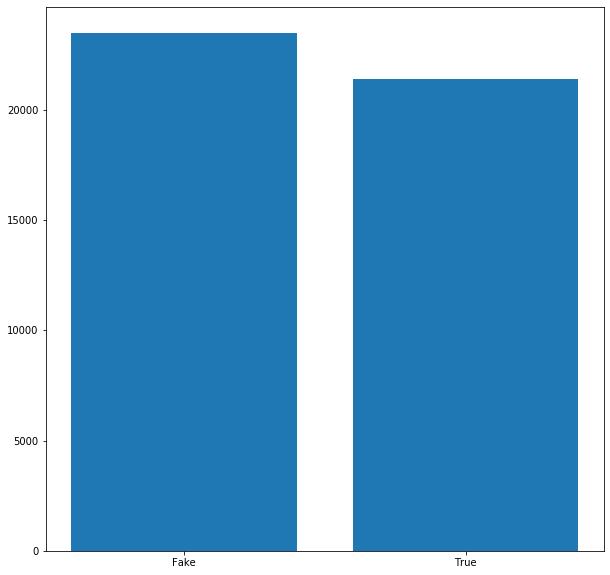

In [109]:
print(df.Label.value_counts().sort_values(ascending=False))
plt.figure(figsize=(10,10))
plt.bar(df.Label.value_counts().keys(),df.Label.value_counts().values)

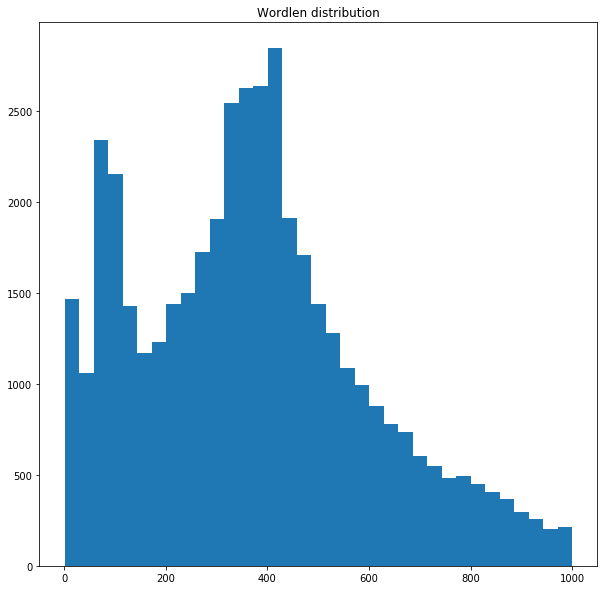

In [116]:
plt.figure(figsize=(10,10))
_ = plt.hist(statfix(df.text.apply(lambda x: len(str(x).split(' ')))),bins=35)
plt.title('Wordlen distribution')
plt.show()

In [110]:
for i in df.subject.unique():
    df[i] = df.subject.apply(lambda x: 1 if x == i else 0)
df.drop('subject',axis=1,inplace=True)
df

,title,text,date,Label,politicsNews,worldnews,News,politics,Government News,left-news,US_News,Middle-east
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,"December 31, 2017",True,1,0,0,0,0,0,0,0
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,"December 29, 2017",True,1,0,0,0,0,0,0,0
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,"December 31, 2017",True,1,0,0,0,0,0,0,0
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,"December 30, 2017",True,1,0,0,0,0,0,0,0
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,"December 29, 2017",True,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
23476,McPain: John McCain Furious That Iran Treated ...,21st Century Wire says As 21WIRE reported earl...,"January 16, 2016",Fake,0,0,0,0,0,0,0,1
23477,JUSTICE? Yahoo Settles E-mail Privacy Class-ac...,21st Century Wire says It s a familiar theme. ...,"January 16, 2016",Fake,0,0,0,0,0,0,0,1
23478,Sunnistan: US and Allied ‘Safe Zone’ Plan to T...,Patrick Henningsen 21st Century WireRemember ...,"January 15, 2016",Fake,0,0,0,0,0,0,0,1
23479,How to Blow $700 Million: Al Jazeera America F...,21st Century Wire says Al Jazeera America will...,"January 14, 2016",Fake,0,0,0,0,0,0,0,1


<Figure size 1080x1080 with 0 Axes>

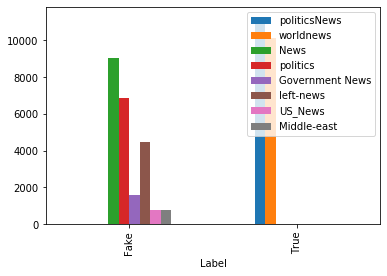

In [111]:
plt.figure(figsize=(15,15))
_ = df.groupby('Label').sum().plot.bar()

### Dataset preparation

In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split
from gensim.models import Word2Vec

import string

import pickle

from nltk.stem import PorterStemmer
from nltk.corpus import stopwords

In [17]:
W2V_text = Word2Vec(df.CleanText.apply(lambda x: x.split(' ')), min_count=1,size= 300,workers=3, window =4, sg = 1)
tfidf_text = TfidfVectorizer(analyzer='word')
tfidf_text.fit(df.CleanText)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

In [19]:
W2V_title = Word2Vec(df.CleanTitle.apply(lambda x: x.split(' ')), min_count=1,size= 300,workers=3, window =4, sg = 1)
tfidf_title = TfidfVectorizer(analyzer='word')
tfidf_title.fit(df.CleanTitle)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

In [86]:
df_train, df_test, _, _ = train_test_split(df[['CleanText','CleanTitle','Label']], df['Label'], test_size=0.2, random_state=42)

In [4]:
#Text processing



def get_dataset(data, labeled=True, upgraded=True, tfidfs=None, w2vs=None):
    y_labels_dict = {'True':1,'Fake':0}
    
    X = data.CleanText.apply(lambda x: process_line(x, upgraded, tfidf=tfidfs[0], w2v=w2vs[0])).to_numpy()
    X_fixed = []
    for i in range(len(X)):
        try:
            X_fixed.append(list(X[i]))
        except:
            X_fixed.append([0 for i in range(300)])
    X_fixed = np.array(X_fixed)
    
    X_title = data.CleanTitle.apply(lambda x: process_line(x, upgraded, tfidf=tfidfs[1], w2v=w2vs[1])).to_numpy()
    X_title_fixed = []
    for i in range(len(X_title)):
        try:
            X_title_fixed.append(list(X_title[i]))
        except:
            X_title_fixed.append([0 for i in range(300)])

    X_title_fixed = np.array(X_title_fixed)
    
    X = np.concatenate((X_fixed, X_title_fixed),axis=1)
    
    if labeled:
        y = np.array(data.Label.apply(lambda x: y_labels_dict[x]).values)
        return X, y
    
    return X

In [88]:
X_train, y_train = get_dataset(df_train, tfidfs=[tfidf_text,tfidf_title], w2vs=[W2V_text,W2V_title])
X_train.shape, df_train.shape

((35918, 600), (35918, 3))

In [89]:
X_test, y_test = get_dataset(df_test, tfidfs=[tfidf_text,tfidf_title], w2vs = [W2V_text,W2V_title])
X_test.shape, df_test.shape

((8980, 600), (8980, 3))

In [90]:
df_test.shape

(8980, 3)

In [92]:
y_test.sum()/y_test.shape[0]

0.4821826280623608

In [8]:
X_train = pd.read_csv('train.csv',sep=',',index_col=0)
y_train = X_train['Label']
X_train.drop('Label',axis=1,inplace=True)

X_test = pd.read_csv('test.csv',sep=',',index_col=0)
y_test = X_test['Label']
X_test.drop('Label',axis=1,inplace=True)

In [9]:
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from sklearn.metrics import classification_report, roc_auc_score

/opt/anaconda3/lib/python3.7/site-packages/lightgbm/__init__.py:48: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [10]:
lgbmc = LGBMClassifier()
RF = RandomForestClassifier()
SVM = SVC()

In [11]:
lgbmc.fit(X_train, y_train)
RF.fit(X_train, y_train)
SVM.fit(X_train, y_train)

SVC()

In [12]:
pred_lgbmc = lgbmc.predict(X_test)
pred_RF = RF.predict(X_test)
pred_SVM = SVM.predict(X_test)

In [13]:
print('LGBM:')
print(classification_report(y_test, pred_lgbmc))
print('\nRF:')
print(classification_report(y_test, pred_RF))
print('\nSVM:')
print(classification_report(y_test, pred_SVM))

LGBM:
              precision    recall  f1-score   support

           0       0.94      0.95      0.95      4650
           1       0.95      0.94      0.94      4330

    accuracy                           0.95      8980
   macro avg       0.95      0.95      0.95      8980
weighted avg       0.95      0.95      0.95      8980


RF:
              precision    recall  f1-score   support

           0       0.93      0.94      0.93      4650
           1       0.93      0.92      0.93      4330

    accuracy                           0.93      8980
   macro avg       0.93      0.93      0.93      8980
weighted avg       0.93      0.93      0.93      8980


SVM:
              precision    recall  f1-score   support

           0       0.95      0.95      0.95      4650
           1       0.94      0.95      0.94      4330

    accuracy                           0.95      8980
   macro avg       0.95      0.95      0.95      8980
weighted avg       0.95      0.95      0.95      8980



In [104]:
from joblib import dump, load

In [105]:
dump(lgbmc, 'lgbmc.joblib')
dump(RF, 'RF.joblib')
dump(SVM, 'SVM.joblib')

['SVM.joblib']

In [106]:
W2V_text.save("word2vec_text.model")
W2V_title.save("word2vec_title.model")

with open('vectorizer_text.pk', 'wb') as fin:
    pickle.dump(tfidf_text, fin)
    

with open('vectorizer_title.pk', 'wb') as fin:
    pickle.dump(tfidf_title, fin)

In [14]:
with open('LGBMC.pk', 'wb') as fin:
    pickle.dump(lgbmc, fin)
    
with open('RF.pk', 'wb') as fin:
    pickle.dump(RF, fin)
    
with open('SVM.pk', 'wb') as fin:
    pickle.dump(SVM, fin)

In [1]:
import sklearn
print(sklearn.__version__)

0.24.2


In [127]:
!pip install scikit-learn==0.24.2

  Using cached scikit_learn-0.24.2-cp37-cp37m-macosx_10_13_x86_64.whl (7.2 MB)
  Using cached threadpoolctl-2.1.0-py3-none-any.whl (12 kB)
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.21.3
    Uninstalling scikit-learn-0.21.3:
      Successfully uninstalled scikit-learn-0.21.3


In [122]:
!/opt/anaconda3/bin/python -m pip install --upgrade pip

  Using cached pip-21.1.2-py3-none-any.whl (1.5 MB)
  Attempting uninstall: pip
    Found existing installation: pip 21.0.1
    Uninstalling pip-21.0.1:
      Successfully uninstalled pip-21.0.1


In [19]:
tfidf_text = pickle.load(open("/Users/rustemmatiev/Projects/FakeNewsClassifier/models/vectorizer_text.pk", "rb"))
tfidf_title = pickle.load(open("/Users/rustemmatiev/Projects/FakeNewsClassifier/models/vectorizer_title.pk", "rb"))

W2V_text = Word2Vec.load('/Users/rustemmatiev/Projects/FakeNewsClassifier/models/word2vec_text.model')
W2V_title = Word2Vec.load('/Users/rustemmatiev/Projects/FakeNewsClassifier/models/word2vec_title.model')

/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator TfidfTransformer from version 0.21.3 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator TfidfVectorizer from version 0.21.3 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [74]:
def clean_text(text):
    ps = PorterStemmer()
    
    #print('Clearing...')
    
    text = ''.join([c if c not in string.punctuation else ' ' for c in text])
    text = text.lower()
    text = ' '.join([word for word in text.split(' ') if word not in set(stopwords.words('english'))])
    
    #print('Stemming...')
    text = ' '.join([ps.stem(word) for word in text.split(' ')])
    
    text = text.rstrip(' ').lstrip(' ')
    text = re.sub(' +', ' ', text)
    
    #print('Done!')
    
    return text

def process_line(line, upgraded=True, tfidf=None, w2v=None):
    tf_test_str = tfidf.transform([line]).toarray()[0]
    tf_test_dict = {}
    for i in tfidf.vocabulary_.keys():
        tf_test_dict[i] = tf_test_str[tfidf.vocabulary_[i]]

    final_vector = []
    for word in line.split(' '):
        if (word in w2v.wv) and (word in tf_test_dict.keys()):
            if upgraded == True:
                vector = w2v.wv[word]*tf_test_dict[word]
            else:
                vector = w2v.wv[word]
            final_vector.append(vector)

    final_vector = np.array(final_vector)
    final_vector = np.mean(final_vector, axis=0)


    return final_vector

In [75]:
for i in range(int(df.shape[0]/2)):
    print(i)
    title_line = process_line(clean_text(df.title.values[i]), tfidf=tfidf_title, w2v=W2V_title)
    text_line = process_line(clean_text(df.text.values[i]), tfidf=tfidf_text, w2v=W2V_text)

    final_line = np.concatenate((text_line, title_line),axis=0)
    final_line = final_line.reshape(1,-1)

    if lgbmc.predict(final_line)[0] != 0:
        print('HERE!')
    

0
HERE!
1
HERE!
2
HERE!
3
HERE!
4
HERE!
5
HERE!
6
HERE!
7
HERE!
8
HERE!
9
HERE!
10
HERE!
11
HERE!
12
HERE!
13
HERE!
14
HERE!
15
HERE!
16
HERE!
17
HERE!
18
HERE!
19
HERE!
20
HERE!
21


KeyboardInterrupt: 

In [73]:
title_line = process_line(clean_text(df.title.values[4]), tfidf=tfidf_title, w2v=W2V_title)
print(title_line)
text_line = process_line(df.text.values[4], tfidf=tfidf_text, w2v=W2V_text)

final_line = np.concatenate((text_line, title_line),axis=0)
final_line = final_line.reshape(1,-1)

trump want postal servic charg much amazon shipment
2.67414766160001
None
9.231414900053851


ValueError: zero-dimensional arrays cannot be concatenated

In [39]:
title_line.shape

()

In [40]:
df.title.values[4]

"Trump wants Postal Service to charge 'much more' for Amazon shipments"

In [41]:
process_line(df.title.values[4], tfidf=tfidf_title, w2v=W2V_title)

/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


nan

In [76]:
df.title.values[273], df.text.values[273]

('White House says focused on getting lowest possible corporate tax rate',
 '(Reuters) - The White House said on Thursday it was focusing on getting the lowest corporate rate possible in tax reform legislation being considered on Capitol Hill. “Fifteen (percent) is better than 20, 20 is better than 22 and 22 is better than what we have,” White House spokeswoman Sarah Sanders told reporters. ')

In [77]:
title_line = process_line(clean_text(df.title.values[273]), tfidf=tfidf_title, w2v=W2V_title)
text_line = process_line(clean_text(df.text.values[273]), tfidf=tfidf_text, w2v=W2V_text)

final_line = np.concatenate((text_line, title_line),axis=0)
final_line = final_line.reshape(1,-1)

lgbmc.predict(final_line)[0]

1

In [81]:
lgbmc.predict_proba(final_line)[0][lgbmc.predict(final_line)[0]]

0.768936803616955